<a href="https://colab.research.google.com/github/mariabandeira/Projeto_Final_IIA/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install nltk

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [ ]:
from nltk import pos_tag
from nltk.tokenize import word_tokenize

nltk.download('averaged_perceptron_tagger')

## Web scrapping Amazon reviews

In [ ]:
# fontes:
# https://www.kaggle.com/code/bhardwajshivam121/web-scrapping-amazon
# https://www.kaggle.com/code/nikhilraj7700/web-scrapping-code-python-beautifulsoup
# perplexity

import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL da página da Amazon
url = "https://www.amazon.com.br/dp/B09SWTG9GF?ref=ods_erd_dpcc_ttl_k11_rc_nd_ucc"

# Realizar uma solicitação HTTP para a página
response = requests.get(url)

# Verificar se a solicitação foi bem-sucedida
if response.status_code == 200:
    # Parsear o conteúdo HTML da página com BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    names = (soup.find_all('span',class_='a-profile-name'))

    cust_name = []
    for i in range(0,len(names)):
      #get_text() removes all the tags and extract text
      cust_name.append(names[i].get_text())

    title = list(soup.find_all(class_='review-title-content'))

    review_title = []
    for i in range(0,len(title)):
      review_title.append(title[i].get_text())

    #to remove '\n'from list of comment heading
    review_title[:] = [review_titles.rstrip('\n')
                for review_titles in review_title] #remove \n

    rating = list(soup.find_all(class_ = 'review-rating'))

    rate = []
    for i in range(0,len(rating)):
      rate.append(rating[i].get_text())

    rate = []
    for i in range(0,len(rating)):
      rate.append(rating[i].get_text()[0:1])

    new_rate = rate[2:12]

    df=pd.DataFrame()
    df['Customer Name'] = cust_name
    df['Review Title'] = review_title
    df['Rating'] = new_rate
    df

    # Criar um dicionário para armazenar as informações das reviews
    reviews_data = []

    # Encontrar a seção com as reviews
    reviews_section = soup.find('div', {'id': 'reviews'})

    # Encontrar as reviews individuais
    reviews = soup.find_all('div', {'data-hook': 'review'})
    for item in reviews:
        review={'body':item.find('span', {'data-hook': 'review-body'}).text.strip()}
        reviews_data.append(review)

    '''
    # Iterar sobre as reviews e extrair as informações
    for review in reviews:
        # Encontrar o título da review
        title = review.find('span', {'data-hook': 'review-title'}).text

        # Encontrar a nota da review
        rating = review.find('i', {'data-hook': 'review-rating'}).text

        # Encontrar o texto da review
        text = review.find('span', {'data-hook': 'review-body'}).text

        # Armazenar as informações da review no dicionário
        reviews_data.append({
            'title': title,
            'rating': rating,
            'text': text
        })
    '''
    # Criar um DataFrame com as informações das reviews
    reviews_df = pd.DataFrame(reviews_data)

    # Salvar o DataFrame em um arquivo CSV
    reviews_df.to_csv('amazon_reviews.csv', index=False)

else:
    print(f"Erro ao acessar a página: {response.status_code}")

ValueError: Length of values (3) does not match length of index (8)

## Sentiment Analysis

In [ ]:
df = pd.read_csv()

In [ ]:
df.head()

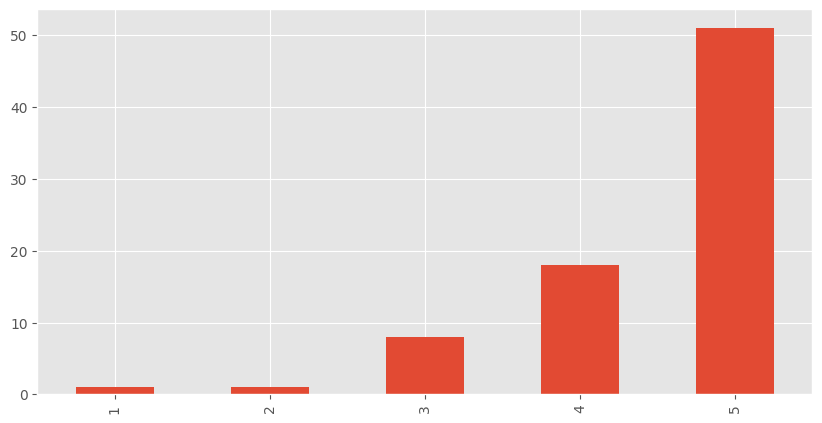

In [57]:
ax = df['stars'].value_counts().sort_index().plot(kind='bar', title='', figsize=(10,5))
ax.set_xlabel('')
plt.show()

### Basic NLTK

In [ ]:
example = df['Text'][50]
print(example)

In [ ]:
tokens = nltk.word_tokenize(example)

In [ ]:
#token pos
tagged = nltk.pos_tag(tokens)

In [ ]:
#
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint() #pretty print

### Vader Sentiment Scoring

In [68]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [20]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [ ]:
sia.polarity_scores('This is the worst thing ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [ ]:
sia.polarity_scores(example)

In [ ]:
# Run on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['Text']
  myid = row['Id']
  res[myid] = sia.polarity_scores(text)

In [ ]:
from operator import index
vaders = pd.DataFrame(res).T
vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(df, how='left')

In [ ]:
# Sentiment Score and metadata
vaders

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound score by Amazon Star Review')
plt.show()

In [ ]:
fig, axs = plt.subplotes(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### Pretrained Model

In [13]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [14]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
  }

  return scores_dict

In [16]:
df = pd.read_csv('/content/B006UACRTG.csv', sep=';')

In [17]:
df['Id'] = df.index

In [18]:
df = df.dropna()

In [21]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
    text = row['text']
    myid = row['Id']
    roberta_result = polarity_scores_roberta(text)
    res[myid] = roberta_result
  except RuntimeError:
    print(f'Broke for id {myid}')

  0%|          | 0/17 [00:00<?, ?it/s]

Broke for id 1


In [22]:
results_df = pd.DataFrame(res).T

In [23]:
results_df

,roberta_neg,roberta_neu,roberta_pos
0,0.099080,0.400952,0.499968
2,0.627624,0.340450,0.031926
3,0.441203,0.424909,0.133888
4,0.509610,0.351208,0.139182
5,0.906813,0.077085,0.016102
6,0.641972,0.305956,0.052072
8,0.333339,0.489318,0.177343
9,0.452152,0.455626,0.092222
10,0.141160,0.776366,0.082474
11,0.650062,0.311850,0.038088


In [24]:
#results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [25]:
results_df

,Id,roberta_neg,roberta_neu,roberta_pos,username,title,date,region,text,stars
0,0,0.099080,0.400952,0.499968,Afterhourshop,Not bad AT ALL. Better for me than the $2K X-R...,"October 26, 2020",United States,"Ok, so I have the $2K i1 Pro2 and I got this a...",4
1,2,0.627624,0.340450,0.031926,Grey,works fine,"April 5, 2014",United States,I use 3rd party ink from Precision Colors. Aft...,4
2,3,0.441203,0.424909,0.133888,Michael,The Final Step to great looking pictures,"August 31, 2015",United States,The final step to great looking pictures. You ...,5
3,4,0.509610,0.351208,0.139182,Michael,"fine software, nice tech -- very poor housing ...","January 29, 2023",United States,The Spyder Print is capable of producing quite...,2
4,5,0.906813,0.077085,0.016102,X,"Device failed after 14 months of use, tech sup...","February 14, 2023",United States,Used the device for about a year on an off wit...,1
5,6,0.641972,0.305956,0.052072,Bruce Fredette,They don't all work the same,"May 22, 2014",United States,I had one of these that worked very well. This...,3
6,8,0.333339,0.489318,0.177343,Roy Lobenhofer,Not as easy as I had hoped,"October 14, 2013",United States,I print my pictures on an Epson 1430 and get d...,3
7,9,0.452152,0.455626,0.092222,John Isner,It gets really dirty and you can't clean it,"March 18, 2022",United States,The cradle and the spectro of my Spyderprint 3...,3
8,10,0.141160,0.776366,0.082474,77792602,De muy mala calidad y encima no dejan devolver...,"March 25, 2024",United States,De muy mala calidad y encima no dejan devolver...,1
9,11,0.650062,0.311850,0.038088,T. J. Muszynski,Big improvement over the mfg icc profile,"October 27, 2022",United States,I’ve been unhappy with the screen to print mat...,5


In [103]:
results_df['roberta_pos'].sum()

4.3846135

In [104]:
results_df['roberta_neu'].sum()

4.8464613

In [105]:
results_df['roberta_neg'].sum()

6.768925

In [26]:
for i, row in tqdm(results_df.iterrows(), total=len(results_df)):
  if row['roberta_neg'] >= row['roberta_pos']:
    negative_text = row['text']
  else:
    positive_text = row['text']

  0%|          | 0/16 [00:00<?, ?it/s]

In [115]:
positive_text

'Another very big advantage of SpyderPRINT is that you can quickly and easily make specific printer profiles for different lighting conditions. The not-so-good part is that Spyder products have never worked **for me** without multiple adjustments, and that\'s why I subtracted the two stars. I\'ve used ColorVision and DataColor (the company changed its name) products to calibrate my monitors and profile my printers ever since the products were available, probably over a twelve or thirteen year time period, and several versions of the ColorVision/DataColor Spyder products, several printers and a few different monitors. The monitor calibration programs have always worked well. The printer profiling packages have always needed multiple adjustments. In summary - invaluable in terms of speed and ease of adjustment of printer profiles, but profiles will need adjustment, probably multiple adjustments before you get that near-perfect match between monitor and printer. Please note again that alt

In [30]:
import string
'''
for text in df['text']:
  if df['roberta_neg'] > df['region']
    negative_text = df['text']
  else:
    positive_text = df['text']

positive_text = [str(frase) for frase in df['positive_sentences']]
positive_text = ' '.join(positive_text)

negative_text = [str(frase) for frase in df['negative_sentences']]
negative_text = ' '.join(negative_text)
'''

stopwords = nltk.corpus.stopwords.words('english')
punctuation = string.punctuation

positive_text = positive_text.lower()
negative_text = negative_text.lower()

wp = Word(positive_text)
lemma_pos = TextBlob(positive_text)
" ". join([w.lemmatize() for w in lemma_pos.words])

wn = Word(negative_text)
lemma_neg = TextBlob(negative_text)
" ". join([w.lemmatize() for w in lemma_neg.words])

pos_tokens = word_tokenize(positive_text)
neg_tokens = word_tokenize(negative_text)

pos_tokens = [word for word in pos_tokens if word not in stopwords]
neg_tokens = [word for word in neg_tokens if word not in stopwords]

clean_pos_tokens = []
clean_neg_tokens = []

for token in pos_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_pos_tokens.append(clean_token)

for token in neg_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_neg_tokens.append(clean_token)

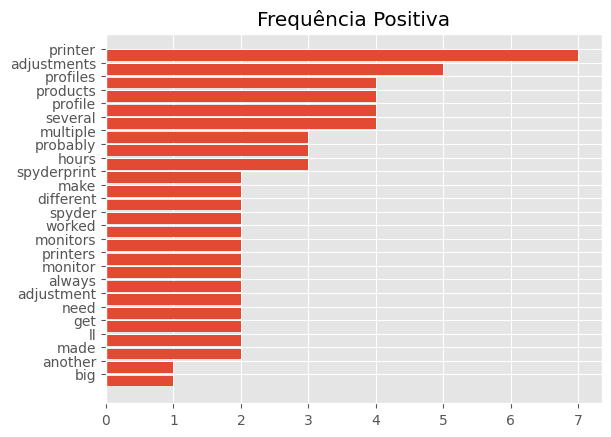

In [31]:
from collections import Counter

pos_freq = dict(Counter(clean_pos_tokens))
#pos_freq.pop('q')
#pos_freq.pop('pra')
pos_popular_words = sorted(pos_freq, key = pos_freq.get, reverse = True)

plt.barh(range(25), [pos_freq[w] for w in reversed(pos_popular_words[0:25])])
plt.yticks([x + 0.5 for x in range(25)], reversed(pos_popular_words[0:25]))
plt.title('Frequência Positiva')
plt.show()

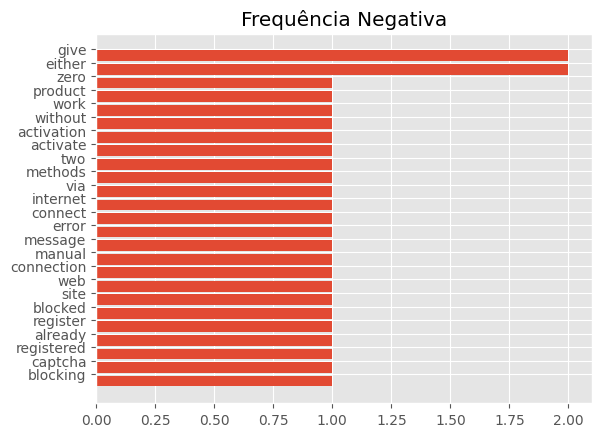

In [32]:
neg_freq = dict(Counter(clean_neg_tokens))
#neg_freq.pop('q')
pos_popular_words = sorted(neg_freq, key = neg_freq.get, reverse = True)

plt.barh(range(25), [neg_freq[w] for w in reversed(pos_popular_words[0:25])])
plt.yticks([x + 0.5 for x in range(25)], reversed(pos_popular_words[0:25]))
plt.title('Frequência Negativa')
plt.show()

In [38]:
def filter_words_by_pos(words_list, pos_class):
    tagged_words = pos_tag(word_tokenize(' '.join(words_list)))
    filtered_words = [word for word, pos in tagged_words if pos == pos_class]
    return filtered_words

# Exemplo de uso da função
pos_class = 'NN'  # Substantivos (nouns)
filtered_pos_nouns = filter_words_by_pos(clean_pos_tokens, pos_class)
filtered_neg_nouns = filter_words_by_pos(clean_neg_tokens, pos_class)
print(filtered_pos_nouns)
print(filtered_neg_nouns)

['advantage', 'spyderprint', 'printer', 'part', 'spyder', 'colorvision', 'datacolor', 'company', 'name', 'year', 'time', 'period', 'spyder', 'calibration', 'ease', 'adjustment', 'printer', 'adjustment', 'match', 'monitor', 'printer', 'please', 'note', 'll', 'put', 'paper', 'get', 'opinion', 'll', 'custom', 'printer', 'profile', 'case', 'printer', 'spyderprint', 'day']
['zero', 'product', 'work', 'activation', 'internet', 'connect', 'error', 'message', 'connection', 'site', 'register', 'way', 'support', 'fix']


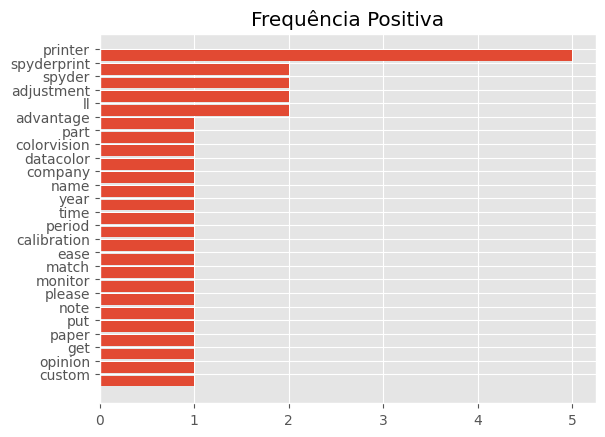

In [37]:
pos_freq = dict(Counter(filtered_pos_nouns))
#pos_freq.pop('q')
#pos_freq.pop('pra')
pos_popular_words = sorted(pos_freq, key = pos_freq.get, reverse = True)

plt.barh(range(25), [pos_freq[w] for w in reversed(pos_popular_words[0:25])])
plt.yticks([x + 0.5 for x in range(25)], reversed(pos_popular_words[0:25]))
plt.title('Frequência Positiva')
plt.show()

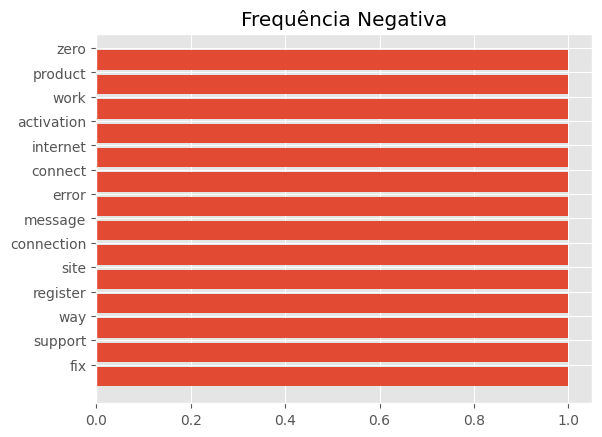

In [46]:
neg_freq = dict(Counter(filtered_neg_nouns))
#neg_freq.pop('q')
#neg_freq.pop('pra')
neg_popular_words = sorted(neg_freq, key = neg_freq.get, reverse = True)

plt.barh(range(14), [neg_freq[w] for w in reversed(neg_popular_words[0:14])])
plt.yticks([x + 0.5 for x in range(14)], reversed(neg_popular_words[0:14]))
plt.title('Frequência Negativa')
plt.show()

### Combine and Compare

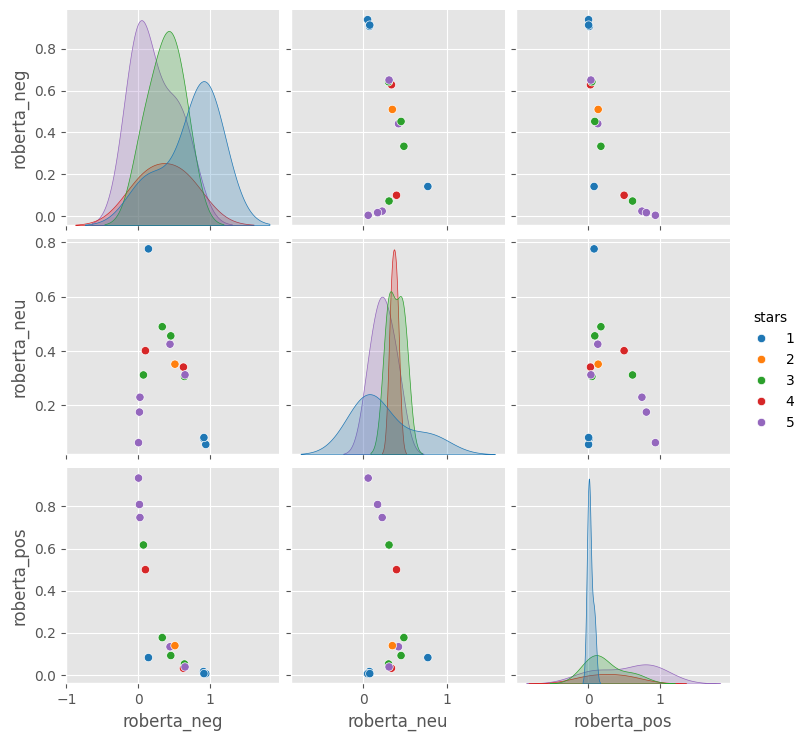

In [106]:
sns.pairplot(data=results_df,
             vars=['roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='stars',
            palette='tab10')
plt.show()

In [87]:
results_df.query('stars == 1') \
    .sort_values('roberta_pos', ascending=False)['text'].values[0]

'The vacuum does a great job when it is working. After 3 weeks I started receiving errors after every time I used it. Their customer support sucks. After attempting to troubleshoot it they told me to send it back. They essentially told me to film myself giving the return package to the delivery person and if it gets lost in the mail then they will attempt to help me. Instead of jumping through all their hoops and gambling on shipping the product back and hoping nothing happens to the package along the way I decided to work with Amazon for a replacement which was a much more comforting experience. The other reviews about the extended turnaround/repair time also scared me into not wanting to deal with their support any longer than I had to. Here is the Roborock\'s customer support message containing the return instructions. Judge it for yourself: " Hi there, Thanks for your reply. Attached file is UPS prepaid label you could print out to ship the device to us. The shipping label doesn\'t

In [84]:
results_df.query('stars == 5') \
    .sort_values('roberta_neg', ascending=False)['text'].values[0]

"I've owned multiple Ecovac robot vacuums, and I finally had enough of their issues to try something new. So far, I'm extremely happy with the Roborock. The vacuum is way more intelligent. It doesn't get stuck at all like the Ecovac I had, which would go haywire and back into everything. The Roborock also has many settings you can tweak to fit your life and house. I have a mix of carpet and hard floors and even the actual cleaning function has been hands down better than my previous vacuums. The big test will be to see how the longevity of the dock and vacuum hold up over the next year. However, after a solid 3-4 weeks of vacuum cleaning daily, everything has been working great. I've also not had any issues with the map freaking out and disappearing or creating a new one. I had this problem every other day with the Ecovac and had to go through, delete the map, and have it start all over. It was really interesting as well to see how the Roborock can identify objects correctly; for examp

## Extra: the transformers pipeline

In [54]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [ ]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

## Using Textblob

In [123]:
!pip install -U textblob

In [12]:
!pip install deep-translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.5 MB/s eta 0:00:00


In [124]:
from textblob import TextBlob
from deep_translator import GoogleTranslator
import pandas as pd

In [29]:
import nltk
from nltk.tokenize import word_tokenize
import string
from textblob import TextBlob, Word
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
tradutor = GoogleTranslator(source= "pt", target= "en")

In [ ]:
text = "Eu ODEIO essa música! Mas a letra é muito boa"
traducao = tradutor.translate(text)
blob = TextBlob(traducao)

In [ ]:
# criar uma coluna com as reviews traduzidas para o inglês

In [ ]:
sentiment = blob.sentiment
print(sentiment)

Sentiment(polarity=-0.04500000000000004, subjectivity=0.8400000000000001)


In [ ]:
polarity = blob.sentiment.polarity
subjectivity = blob.sentiment.subjectivity

print(polarity)
print(subjectivity)

-0.04500000000000004
0.8400000000000001


In [29]:
df = pd.read_csv('/content/B0BVB5PTDK.csv', sep=';')

In [30]:
df

,username,title,date,region,text,stars
0,Ls,what r u waiting for?!?!?!?!?!?!?!?!?,"December 23, 2023",United States,I’m in love!!!! Not so much with the price but...,5
1,Jenniferc9695,Perfection Has Arrived,"April 14, 2024",United States,I love my old Roborock. Actually it's not even...,5
2,ctw,Works as stated,"April 14, 2024",United States,NaN,5
3,Dave,"Awesome vacuum, offensive customer support","September 8, 2023",United States,The vacuum does a great job when it is working...,1
4,Heather,Super pleased with this product,"May 4, 2024",United States,NaN,5
...,...,...,...,...,...,...
95,Christopher J.,Much better than iRobot S6,"January 1, 2024",United States,Robots seems to know where it is much more tha...,4
96,Merissa,A product to try,"March 29, 2024",United States,NaN,5
97,SHIPS FROM NYC,App was not working,"January 27, 2024",United States,Had to send it back to factory. So far working...,4
98,Lisa E.,Awesome time saver,"February 8, 2024",United States,NaN,5


In [34]:
df = df.dropna()

In [19]:
def sentences_tokenization(text):
  sentences = []
  blob = TextBlob(text)
  for sentence in blob.sentences:
    sentences.append(str(sentence))

  return sentences

In [36]:
df['sentences'] = df['text'].apply(sentences_tokenization)

<ipython-input-36-2d181a1b4d31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentences'] = df['text'].apply(sentences_tokenization)


In [ ]:
df['sentences_en'] = df['reviews_en'].apply(sentences_tokenization)

In [37]:
def sentiment_analysis(sentences):
  sentiments = []
  for sentence in sentences:
    blob = TextBlob(sentence)
    sentiment = blob.sentiment.polarity
    sentiments.append(sentiment)

  return sentiments

In [38]:
df['sentences_sentiments'] = df['sentences'].apply(sentiment_analysis)

<ipython-input-38-41df6f1781b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentences_sentiments'] = df['sentences'].apply(sentiment_analysis)


In [39]:
df['positive_sentences'] = df.apply(lambda x: [frase for frase, sentimento in zip(x['sentences'], x['sentences_sentiments']) if sentimento > 0], axis=1)

<ipython-input-39-c40ce6280389>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['positive_sentences'] = df.apply(lambda x: [frase for frase, sentimento in zip(x['sentences'], x['sentences_sentiments']) if sentimento > 0], axis=1)


In [40]:
df['negative_sentences'] = df.apply(lambda x: [frase for frase, sentimento in zip(x['sentences'], x['sentences_sentiments']) if sentimento < 0], axis=1)

<ipython-input-40-30b266d9537c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['negative_sentences'] = df.apply(lambda x: [frase for frase, sentimento in zip(x['sentences'], x['sentences_sentiments']) if sentimento < 0], axis=1)


In [41]:
df

,username,title,date,region,text,stars,sentences,sentences_sentiments,positive_sentences,negative_sentences
0,Ls,what r u waiting for?!?!?!?!?!?!?!?!?,"December 23, 2023",United States,I’m in love!!!! Not so much with the price but...,5,"[I’m in love!!!!, Not so much with the price b...","[1.0, 0.1, -0.15, -0.09999999999999999, 0.0, 0...","[I’m in love!!!!, Not so much with the price b...",[I was hesitant to purchase a $1600 vacuum/ mo...
1,Jenniferc9695,Perfection Has Arrived,"April 14, 2024",United States,I love my old Roborock. Actually it's not even...,5,"[I love my old Roborock., Actually it's not ev...","[0.3, 0.14444444444444446, -0.2333333333333333...","[I love my old Roborock., Actually it's not ev...","[But with this S8 Pro Ultra, they have fixed a..."
3,Dave,"Awesome vacuum, offensive customer support","September 8, 2023",United States,The vacuum does a great job when it is working...,1,[The vacuum does a great job when it is workin...,"[0.39583333333333337, 0.0, -0.3, 0.0, 0.0, 0.2...",[The vacuum does a great job when it is workin...,"[Their customer support sucks., The other revi..."
5,J. Dyer,Clean floors and hyper accurate mapping,"February 9, 2024",United States,"I’ve had many robot vacuums, high-end iRobot a...",4,"[I’ve had many robot vacuums, high-end iRobot ...","[0.4, 0.5833333333333334, 0.020606060606060607...","[I’ve had many robot vacuums, high-end iRobot ...",[Since it cleans the mop head it’s not just pu...
6,L. H.,Worth the $,"April 22, 2024",United States,I moved my other brand robot floor cleaner to ...,5,[I moved my other brand robot floor cleaner to...,"[-0.10833333333333334, 1.0, 0.3333333333333333...","[This one is impressive., I schedule my main r...",[I moved my other brand robot floor cleaner to...
...,...,...,...,...,...,...,...,...,...,...
92,Julia Z,I: We Love This Machine,"April 20, 2024",United States,"The Best thing ever. Sweeps, mops, cleans itse...",5,"[The Best thing ever., Sweeps, mops, cleans it...","[1.0, 0.0, 0.0, 0.75, 0.0, 0.41666666666666663]","[The Best thing ever., The S5 takes care of th...",[]
94,Chris,So much better than iRobot,"February 7, 2024",United States,So long term iRobot user most recently with a ...,5,[So long term iRobot user most recently with a...,"[0.15, 0.1322222222222222, 0.3681818181818182,...",[So long term iRobot user most recently with a...,[]
95,Christopher J.,Much better than iRobot S6,"January 1, 2024",United States,Robots seems to know where it is much more tha...,4,[Robots seems to know where it is much more th...,"[0.16666666666666669, 0.13636363636363635, 0.4...",[Robots seems to know where it is much more th...,[]
97,SHIPS FROM NYC,App was not working,"January 27, 2024",United States,Had to send it back to factory. So far working...,4,"[Had to send it back to factory., So far worki...","[0.0, 0.3]",[So far working ok. Extended warranty recommen...,[]


In [42]:
positive_text = [str(frase) for frase in df['positive_sentences']]
positive_text = ' '.join(positive_text)

negative_text = [str(frase) for frase in df['negative_sentences']]
negative_text = ' '.join(negative_text)

stopwords = nltk.corpus.stopwords.words('english')
punctuation = string.punctuation

positive_text = positive_text.lower()
negative_text = negative_text.lower()

wp = Word(positive_text)
lemma_pos = TextBlob(positive_text)
" ". join([w.lemmatize() for w in lemma_pos.words])

wn = Word(negative_text)
lemma_neg = TextBlob(negative_text)
" ". join([w.lemmatize() for w in lemma_neg.words])

pos_tokens = word_tokenize(positive_text)
neg_tokens = word_tokenize(negative_text)

pos_tokens = [word for word in pos_tokens if word not in stopwords]
neg_tokens = [word for word in neg_tokens if word not in stopwords]

clean_pos_tokens = []
clean_neg_tokens = []

for token in pos_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_pos_tokens.append(clean_token)

for token in neg_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_neg_tokens.append(clean_token)

In [43]:
print(clean_pos_tokens)

['’', 'love', 'not', 'much', 'price', 'extra', 'time', 'say', 'tempted', 'never', 'believed', 'would', 'actually', 'good', 'job', 'this', 'product', 'amazing', '’', 'able', 'find', 'list', 'errors', 'instruction', 'manual', 'started', 'get', 'really', 'upset', 'finally', 'able', 'find', '1', 'person', 'got', 'response', 'roborock', 'the', 'whole', 'process', 'took', '14', 'minutes', 'some', 'people', 'said', 'vacuums', 'certain', 'days', 'mops', 'others', '’', 'figured', 'set', 'different', 'schedules', 'vacuum', 'mop', 'sunday', 'wednesday', 'friday', 'every', 'often', 'u', 'flip', 'robot', 'clean', 'hair', 'buildup', 'well', 'wipe', 'dock', 'my', 'boyfriend', 'wants', 'project', 'every', '2', 'weeks', 'stays', 'shinny', 'new', 'the', 'directions', 'show', 'picture', 'faucet', 'dropping', 'tap', 'water', 'clean', 'water', 'tank', 'live', 'florida', 'super', 'hard', 'water', 'my', 'boyfriend', '’', 'believe', 'clean', 'floor', 'house', 'it', 'costs', '19', 'bottle', 'u', 'use', 'cap', 

In [44]:
print(clean_neg_tokens)

['hesitant', 'purchase', '1600', 'vacuum', 'mop', 'reading', 'least', '50', 'reviews', 'multiple', 'websites…', 'convinced', 'it', 'took', 'lot', 'longer', 'arrive', 'bc', 'shipped', 'directly', 'roborock', 'arkansas', 'via', 'ups', '’', 'surprised', 'amazon', 'gets', 'delivery', 'date', 'wrong', 'at', 'least', 'point', '’', 'feel', 'like', 'wasted', 'fortune', 'something', 'broken', 'arrived', 'closed', 'door', 'back', 'bedroom', 'bc', '’', 'room', 'everything', 'goes', 'die', 'nowhere', 'even', 'turn', 'around', 'room', 'notice', 'trouble', 'distinguishing', 'btwn', 'inside', 'outside', 'comes', 'contact', 'sliding', 'glass', 'doors', 'shades', 'it', 'tells', 'u', 'long', '’', 'running', 'battery', 'life', 'some', 'people', 'said', 'dirty', 'water', 'tank', 'smell', 'time', 'return', 'home', 'night', 'dump', 'outside', 'rinse', 'sink', 'thought', 'would', 'vacuum', 'entire', 'house', '1st', 'gonback', 'mop', '’', 'works', '2', 'small', 'microfiber', 'mats', 'house', 'she', 'make', 'l

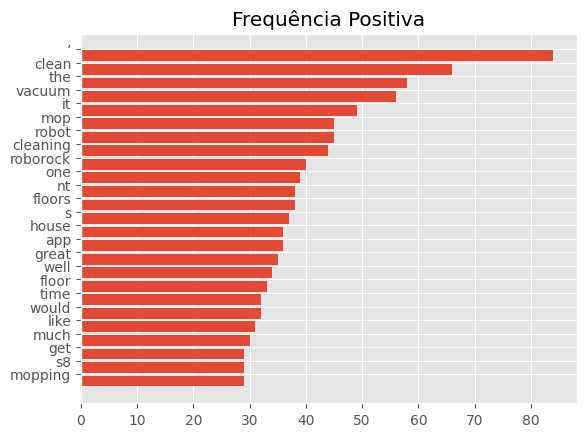

In [48]:
from collections import Counter

pos_freq = dict(Counter(clean_pos_tokens))
#pos_freq.pop('q')
#pos_freq.pop('pra')
pos_popular_words = sorted(pos_freq, key = pos_freq.get, reverse = True)

plt.barh(range(25), [pos_freq[w] for w in reversed(pos_popular_words[0:25])])
plt.yticks([x + 0.5 for x in range(25)], reversed(pos_popular_words[0:25]))
plt.title('Frequência Positiva')
plt.show()

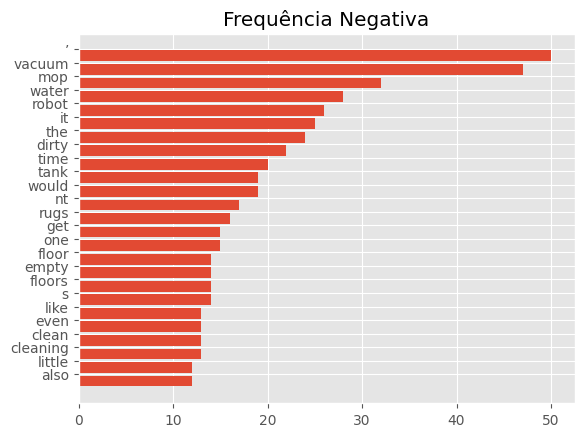

In [50]:
neg_freq = dict(Counter(clean_neg_tokens))
#neg_freq.pop('q')
pos_popular_words = sorted(neg_freq, key = neg_freq.get, reverse = True)

plt.barh(range(25), [neg_freq[w] for w in reversed(pos_popular_words[0:25])])
plt.yticks([x + 0.5 for x in range(25)], reversed(pos_popular_words[0:25]))
plt.title('Frequência Negativa')
plt.show()

In [52]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
nltk.tag.pos_tag(clean_neg_tokens)

In [ ]:
# tentar pegar apenas adjetivos para retornar palavras mais utilizadas
# retornar a média das reviews
# criar interação com usuário

## NRC Lexicon

In [1]:
!pip install NRCLex

In [2]:
# Import required modules
from nrclex import NRCLex
from collections import Counter

In [6]:
df = pd.read_csv('/content/B006UACRTG.csv', sep=';')

In [7]:
df

,username,title,date,region,text,stars
0,Afterhourshop,Not bad AT ALL. Better for me than the $2K X-R...,"October 26, 2020",United States,"Ok, so I have the $2K i1 Pro2 and I got this a...",4
1,JonG,"Usability issues, buggy software, creates tota...","September 16, 2018",United States,I had high expectations of this device given t...,1
2,Grey,works fine,"April 5, 2014",United States,I use 3rd party ink from Precision Colors. Aft...,4
3,Michael,The Final Step to great looking pictures,"August 31, 2015",United States,The final step to great looking pictures. You ...,5
4,Michael,"fine software, nice tech -- very poor housing ...","January 29, 2023",United States,The Spyder Print is capable of producing quite...,2
5,X,"Device failed after 14 months of use, tech sup...","February 14, 2023",United States,Used the device for about a year on an off wit...,1
6,Bruce Fredette,They don't all work the same,"May 22, 2014",United States,I had one of these that worked very well. This...,3
7,DarrenIngram_dot_com,Reasonable,"August 29, 2015",United States,NaN,4
8,Roy Lobenhofer,Not as easy as I had hoped,"October 14, 2013",United States,I print my pictures on an Epson 1430 and get d...,3
9,John Isner,It gets really dirty and you can't clean it,"March 18, 2022",United States,The cradle and the spectro of my Spyderprint 3...,3


In [9]:
df = df.dropna()

In [11]:
texts = [text for text in df['text']] # putting reviews in a list

emotions = []

for text in texts:  # Here we give the song the average emotion in it

    e = NRCLex(text)
    if e.affect_list:  # Verifica se a lista não está vazia
        mode = max(e.affect_list, key=Counter(e.affect_list).get)
        emotions.append(mode)
    else:
        ind = df.loc[df['text'] == text].index
        df = df.drop(ind) # remove songs wich do not contain valid lyrics

df['Emotion'] = emotions

In [12]:
df

,username,title,date,region,text,stars,Emotion
0,Afterhourshop,Not bad AT ALL. Better for me than the $2K X-R...,"October 26, 2020",United States,"Ok, so I have the $2K i1 Pro2 and I got this a...",4,positive
1,JonG,"Usability issues, buggy software, creates tota...","September 16, 2018",United States,I had high expectations of this device given t...,1,positive
2,Grey,works fine,"April 5, 2014",United States,I use 3rd party ink from Precision Colors. Aft...,4,fear
3,Michael,The Final Step to great looking pictures,"August 31, 2015",United States,The final step to great looking pictures. You ...,5,negative
4,Michael,"fine software, nice tech -- very poor housing ...","January 29, 2023",United States,The Spyder Print is capable of producing quite...,2,positive
5,X,"Device failed after 14 months of use, tech sup...","February 14, 2023",United States,Used the device for about a year on an off wit...,1,positive
6,Bruce Fredette,They don't all work the same,"May 22, 2014",United States,I had one of these that worked very well. This...,3,positive
8,Roy Lobenhofer,Not as easy as I had hoped,"October 14, 2013",United States,I print my pictures on an Epson 1430 and get d...,3,anticipation
9,John Isner,It gets really dirty and you can't clean it,"March 18, 2022",United States,The cradle and the spectro of my Spyderprint 3...,3,trust
11,T. J. Muszynski,Big improvement over the mfg icc profile,"October 27, 2022",United States,I’ve been unhappy with the screen to print mat...,5,positive


## Fontes/Ideias

Análise de sentimentos em português utilizando Pytorch e Python

* [Parte 1](https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0)

* [Parte 2](https://medium.com/data-hackers/deploy-de-um-modelo-de-an%C3%A1lise-de-sentimentos-como-uma-rest-api-878c175ad24f)

---

[Construindo um analisador de sentimentos em python](https://acadianschool.com.br/construindo-um-analisador-de-sentimentos-em-python/)

---

[AIpp](https://github.com/TailUFPB/AIpp/tree/main)

---

[tradutor de texto em python](https://www.hashtagtreinamentos.com/tradutor-de-texto-em-python#:~:text=Utilizaremos%20a%20biblioteca%20Deep%2Dtranslator,podemos%20fazer%20no%20pr%C3%B3prio%20site.)

---

[swiftclassifier](https://github.com/biabcaval/swiftclassifier/tree/main)